In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import math 
from scipy.ndimage import zoom
from scipy.special import logsumexp


import os
import sys
import struct
import time

import pandas as pd
import seaborn as sns
import h5py

from tqdm import tqdm
import cv2

%matplotlib inline

In [2]:
subject = "1"

In [3]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"
BETAS_PATH = NSD_ROOT+f"/nsddata_betas/ppdata/subj0{subject}/func1pt8mm/betas_fithrf_GLMdenoise_RR/"
BEHAV_PATH = NSD_ROOT + f"/nsddata/ppdata/subj0{subject}/behav/responses.tsv"

DEVICE = 'cpu'

The idea is that we extract the activations from a resnet50 model, at each stage of its architechture 
for example, for the first stage, we can extract the 56 x 56 output and then upscale it to 425x425, and do the same for remaining three 

# Loading ResNet50 pretrained on ImageNet

In [4]:
from torchvision.models import resnet50, ResNet50_Weights

# New weights with accuracy 80.858%
# model2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2
resnet_model = resnet50(pretrained = True) 

/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
image_data_set = h5py.File(stim_file, 'r')

for key, value in image_data_set.items() :
    print(key,": \n", value,"\n")
    
image_data_73k = np.copy(image_data_set['imgBrick'])
image_data_set.close()

imgBrick : 
 <HDF5 dataset "imgBrick": shape (73000, 425, 425, 3), type "|u1"> 



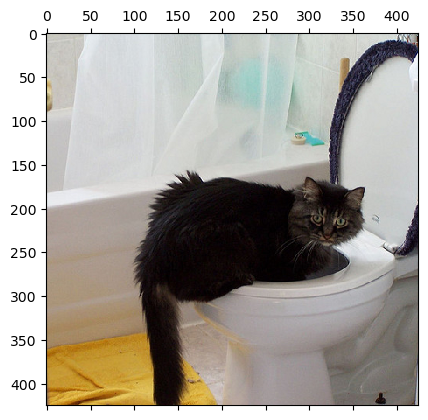

In [6]:
test_image = image_data_73k[1]
plt.matshow(test_image) 

In [7]:
from torchvision import transforms

# Create a preprocessing pipeline
preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [8]:
img_preproc = preprocess(test_image)

# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
batch_img_tensor = torch.unsqueeze(img_preproc, 0) # torch.Size([1, 3, 224, 224])

In [9]:
resnet_model.eval();

In [10]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [11]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
activation = {}

In [13]:
resnet_model.layer1[2].relu.register_forward_hook(get_activation('layer1'))
resnet_model.layer2[3].relu.register_forward_hook(get_activation('layer2'))
resnet_model.layer3[5].relu.register_forward_hook(get_activation('layer3'))
resnet_model.layer4[2].relu.register_forward_hook(get_activation('layer4'))

In [14]:
activation

{}

In [15]:
out = resnet_model(batch_img_tensor)

In [16]:
activation.keys()

dict_keys(['layer1', 'layer2', 'layer3', 'layer4'])

In [17]:
print(activation['layer1'].shape)
print(activation['layer2'].shape)
print(activation['layer3'].shape)
print(activation['layer4'].shape)

torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 2048, 7, 7])


In [18]:
def upscale_activations(activations, output_size = 425):
    '''
    Upscale the activations from ResNet to the size of the COCO images, i.e. (425 x 425)
    
    '''
    
    if activations.ndim == 4: # Contains batch
        shape = activations.shape[1:]
        activations = activations.view(*shape)
        
    # Upscale the image
    averaged_act = activations.mean(axis = 0).numpy() # mean across the channels 
    upscaled_act = cv2.resize(averaged_act, (output_size, output_size), interpolation = cv2.INTER_CUBIC)
    
    return upscaled_act
        

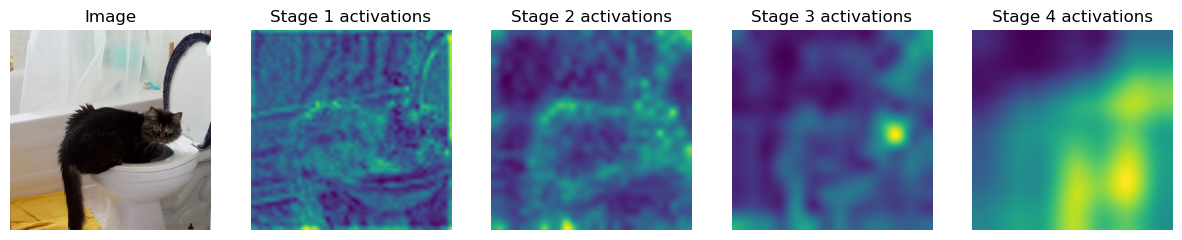

In [19]:
plt.figure(figsize=(15, 5))  
# Plot the test image on the left
plt.subplot(1, 5, 1)  # 1 row, 5 columns (1 for test image, 4 for activations)
plt.imshow(test_image)
plt.title('Image')
plt.axis('off')

# Plot the activations on the right
for i, layer in enumerate(activation.keys(), start=2):
    plt.subplot(1, 5, i)  # 1 row, 5 columns
    plt.imshow(upscale_activations(activation[layer]))
    plt.title(f'Stage {i-1} activations')
    plt.axis('off')

# plt.tight_layout()
plt.show()

# Generate 'saliency maps' from ResNet50 

In [20]:
resp_subj1 = pd.read_csv(BEHAV_PATH, sep ='\t')
resp_subj1['73KID'] =  resp_subj1['73KID'] - 1
resp_subj1['10KID'] = resp_subj1['10KID'] -  1
resp_subj1.head()

,SUBJECT,SESSION,RUN,TRIAL,73KID,10KID,TIME,ISOLD,ISCORRECT,RT,CHANGEMIND,MEMORYRECENT,MEMORYFIRST,ISOLDCURRENT,ISCORRECTCURRENT,TOTAL1,TOTAL2,BUTTON,MISSINGDATA
0,1,1,1,1,46002,625,0.505082,0,1.0,803.529781,0.0,NaN,NaN,0,1.0,1,0,1.0,0
1,1,1,1,2,61882,5012,0.505128,0,1.0,972.261383,0.0,NaN,NaN,0,1.0,1,0,1.0,0
2,1,1,1,3,828,4849,0.505175,0,1.0,742.351236,0.0,NaN,NaN,0,1.0,1,0,1.0,0
3,1,1,1,4,67573,8822,0.505221,0,1.0,747.518479,0.0,NaN,NaN,0,1.0,1,0,1.0,0
4,1,1,1,5,16020,9537,0.505267,0,1.0,547.422774,0.0,NaN,NaN,0,1.0,1,0,1.0,0


In [21]:
img_indices = resp_subj1['73KID']
img_indices.shape

(30000,)

In [49]:
layer_activation = {} 

In [50]:
def get_activation_inside(name):
    def hook(model, input, output):
        layer_activation[name] = output.detach()
    return hook

In [51]:
def generate_maps_resnet(img_indices, model):
    
    # get the image 
    # feed it through resnet and get its output (thatll generate the actiations) 
    # get the actications for each stage
    # append them accordingly 
    
    model.eval();
    
    model.layer1[2].relu.register_forward_hook(get_activation_inside('layer1'))
    model.layer2[3].relu.register_forward_hook(get_activation_inside('layer2'))
    model.layer3[5].relu.register_forward_hook(get_activation_inside('layer3'))
    model.layer4[2].relu.register_forward_hook(get_activation_inside('layer4'))
    
    S_mat_stage1 = np.ones([len(img_indices), 425 , 425], dtype = 'float16')
    S_mat_stage2 = np.ones([len(img_indices), 425 , 425], dtype = 'float16') 
    S_mat_stage3 = np.ones([len(img_indices), 425 , 425], dtype = 'float16') 
    S_mat_stage4 = np.ones([len(img_indices), 425 , 425], dtype = 'float16') 
    
    
    for idx in tqdm(range(0, len(img_indices))): 
        img = image_data_73k[img_indices[idx]]
        img_preproc = preprocess(img)
        
        # Could do batching here (LATER) 
        batch_img_tensor = torch.unsqueeze(img_preproc, 0) # torch.Size([1, 3, 224, 224])
        out = model(batch_img_tensor)
        
        act_layer1 = upscale_activations(layer_activation['layer1'])
        S_mat_stage1[idx, :] = act_layer1
        
        act_layer2 = upscale_activations(layer_activation['layer2'])
        S_mat_stage2[idx, :] = act_layer2
        
        act_layer3 = upscale_activations(layer_activation['layer3'])
        S_mat_stage3[idx, :] = act_layer3
        
        act_layer4 = upscale_activations(layer_activation['layer4'])
        S_mat_stage4[idx, :] = act_layer4
        
                              
    return S_mat_stage1, S_mat_stage2, S_mat_stage3, S_mat_stage4
    

In [52]:
S_mat_stage1, S_mat_stage2, S_mat_stage3, S_mat_stage4 = generate_maps_resnet(img_indices = img_indices, model = resnet_model)

100%|██████████| 30000/30000 [19:28<00:00, 25.67it/s]


In [54]:
np.save(DATA_PATH+"/S_mat_resnet_stage1", S_mat_stage1)

In [59]:
np.save(DATA_PATH+"/S_mat_resnet_stage2", S_mat_stage2)

In [60]:
np.save(DATA_PATH+"/S_mat_resnet_stage3", S_mat_stage3)

In [61]:
np.save(DATA_PATH+"/S_mat_resnet_stage4", S_mat_stage4)

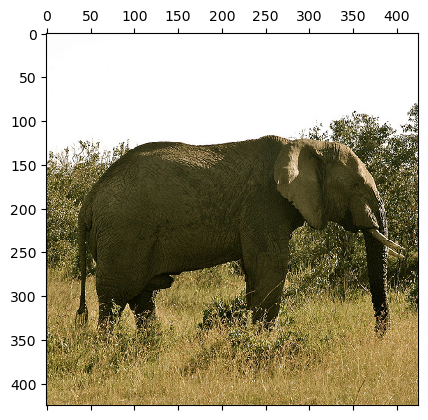

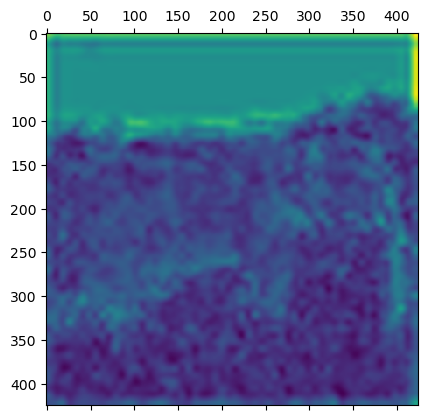

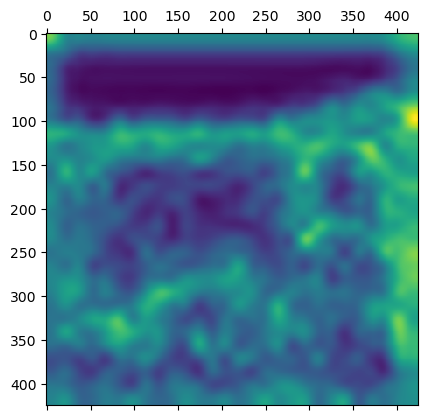

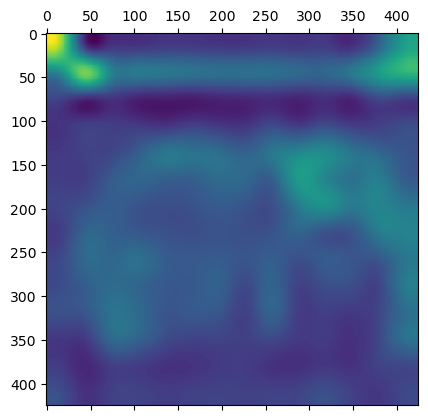

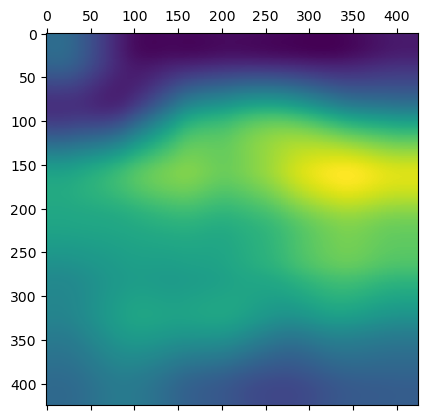

In [58]:
i = 100
plt.matshow(image_data_73k[img_indices[i]])
plt.matshow(S_mat_stage1[i])
plt.matshow(S_mat_stage2[i])
plt.matshow(S_mat_stage3[i])
plt.matshow(S_mat_stage4[i])